In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Cervical Cancer Screening Project 
# Notebook by:
# Samuel Ozechi, Adebowale Akande
# 
# 
# Task:
# Develop an algorithm which accurately identifies and classifies a woman’s cervix type based on images.
# 
# Dataset: 
# intel-mobileodt-cervical-cancer-screening
# 
# The major objectives of this notebook includes:
# 
# Rid the dataset of bad images.  
# Explore the dataset for useful insights in model building. 
# Apply useful image data processes to develop an efficient classifier.
# Build, train and evaluate a classifier using transfer learning.
# Highlight useful steps that can improve the data.

# Importing Libraries

In [2]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten , Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Loading Dataset 

In [3]:
# get the data for training

root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [4]:
# # get data for testing

# test_dir = os.path.join(root_dir,'test', 'test')

# test_files = glob.glob(test_dir+'/*.jpg')

# print(f'''Test files for training: {len(test_files)}''' )

In [5]:
# create dataframe of file and labels
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


# Data Cleaning and Exploration

In [6]:
# describe the dataframe
files_df.describe()

,filepath,label
count,8215,8215
unique,8215,3
top,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
freq,1,4348


In [7]:
# check for duplicates
len(files_df[files_df.duplicated(subset=['filepath'])])

0

In [8]:
# check for damaged files
bad_files = []
for path in (files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)
print(len(bad_files))

3


In [9]:
# # show the bad files
# print(bad_files)

In [10]:
# drop the damaged files
files_df.drop(bad_files, inplace=True)

In [11]:
# check length of files in dataframe
len(files_df)

8212

In [12]:
# check unique labels
files_df['label'].unique()

array(['Type 1', 'Type 3', 'Type 2'], dtype=object)

In [13]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,Num_Values
Type 2,4346
Type 3,2426
Type 1,1440


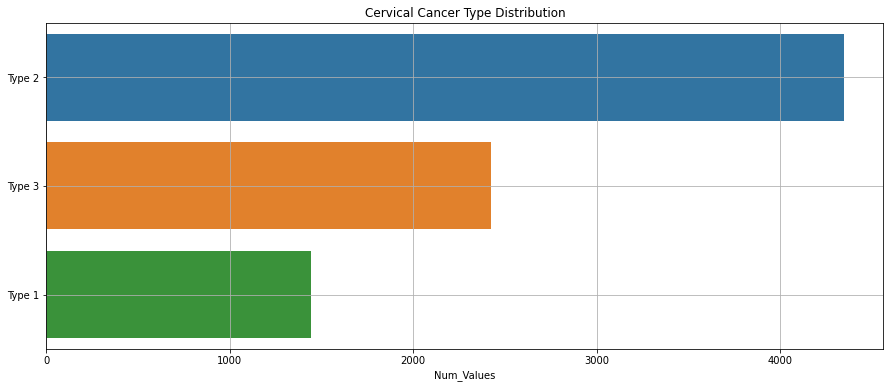

In [14]:
# display barplot of type count
plt.figure(figsize = (15, 6))
sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
plt.title('Cervical Cancer Type Distribution')
plt.grid(True)
plt.show()

### The data distribution plot shows that type 3 class has more datapoints than other types, with type 1  having the least datapoints.

### A pie plot is useful in visualizing the percentage of data distribution.


In [15]:
# display pieplot of label distribution
pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Plot of Type Distribution')
fig.show()

### The pie plot shows that more than half of the dataset belong to the type two class.
### The model built with this dataset is expected to be bias towards the the type 2 class and have less precision for identifying the type 1 class. 

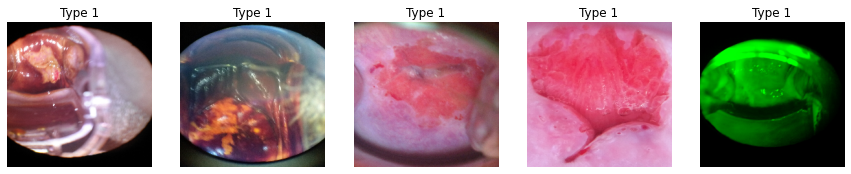

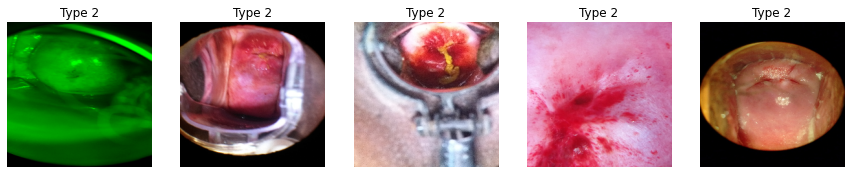

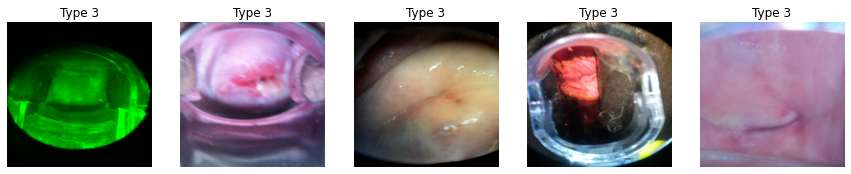

In [16]:
# display sample images of types
for label in ('Type 1', 'Type 2', 'Type 3'):
    filepaths = files_df[files_df['label']==label]['filepath'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

# Data Processing

In [17]:
#  split the data into train  and validation set
train_df, eval_df = train_test_split(files_df, test_size= 0.2, stratify= files_df['label'], random_state= 1)
val_df, test_df = train_test_split(eval_df, test_size= 0.5, stratify= eval_df['label'], random_state= 1)
print(len(train_df), len(val_df), len(test_df))

6569 821 822


In [18]:
# loads images from dataframe
def load_images(dataframe):
    features = []
    filepaths = dataframe['filepath'].values
    labels = dataframe['label'].values
    
    for path in filepaths:
        img = cv2.imread(path)
        resized_img = cv2.resize(img, (180, 180))
        features.append(np.array(resized_img))
    return np.array(features), np.array(labels)

In [19]:
# load training and evaluation data
train_features, train_labels = load_images(train_df)
val_features, val_labels = load_images(val_df)
test_features, test_labels = load_images(test_df)

In [20]:
# check lengths of training and evaluation  sets
len(train_features), len(train_labels), len(test_features), len(test_labels), len(test_features), len(test_labels) 

(6569, 6569, 822, 822, 822, 822)

In [21]:
# get image shape
InputShape = train_features[0].shape
print(InputShape)

(180, 180, 3)


In [22]:
# normalize the features
X_train = train_features/255
X_val  = val_features/255
X_test  = test_features/255

In [23]:
# encode the labels
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(train_labels)
y_val = le.transform(val_labels)
y_test = le.transform(test_labels)

In [24]:
# check unique labels
np.unique(y_train)

array([0, 1, 2])

In [25]:
# initialize image data generator for training and evaluation sets
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip=True,
                                vertical_flip = True)

eval_datagen = ImageDataGenerator()

In [26]:
# apply data augmentation to features
BATCH_SIZE= 32
train_gen = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)
val_gen = eval_datagen.flow(X_val, y_val, batch_size= BATCH_SIZE)
test_gen = eval_datagen.flow(X_test, y_test, batch_size= BATCH_SIZE)

In [27]:
# show shape of each  batch
for data_batch, labels_batch in train_gen:
    print('data batch shape: {} \n labels batch shape: {}'.format(data_batch.shape, labels_batch.shape))
    break

data batch shape: (32, 180, 180, 3) 
 labels batch shape: (32,)


# Model building

In [28]:
# initialize pretrained vgg model base
conv_base = VGG16(weights= 'imagenet', include_top= False, input_shape= (180, 180, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [29]:
# show trainable layers before freezing
print('This is the number of trainable weights '
'before freezing layers in the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights before freezing layers in the conv base: 26


In [30]:
# freeze few layers of pretrained model
for layer in conv_base.layers[:-5]:
    layer.trainable= False

In [31]:
# show trainable layers after freezing
print('This is the number of trainable weights '
'after freezing layers in the conv base:', len(conv_base.trainable_weights))

This is the number of trainable weights after freezing layers in the conv base: 6


In [32]:
# build model 
model = Sequential([conv_base, 
                    Flatten(),
                   Dropout(0.5),
                   Dense(3, activation='softmax')])

In [33]:
# compile model
model.compile(optimizer= Adam(0.0001), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

In [34]:
# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 38403     
Total params: 14,753,091
Trainable params: 7,117,827
Non-trainable params: 7,635,264
_________________________________________________________________


In [35]:
# define training steps
TRAIN_STEPS = len(train_df)//BATCH_SIZE
VAL_STEPS = len(val_df)//BATCH_SIZE

In [36]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience = 20, verbose=1, mode='min', restore_best_weights= True)

checkpoint = ModelCheckpoint('cervicalModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

In [37]:
# train model
history = model.fit(train_gen, steps_per_epoch= TRAIN_STEPS, validation_data=val_gen, validation_steps=VAL_STEPS, epochs= 100,
                   callbacks= [reduceLR, early_stopping, checkpoint])

Epoch 1/100
205/205 [==============================] - 57s 232ms/step - loss: 1.1071 - accuracy: 0.4710 - val_loss: 0.9494 - val_accuracy: 0.5550

Epoch 00001: val_loss improved from inf to 0.94938, saving model to cervicalModel.weights.hdf5
Epoch 2/100
205/205 [==============================] - 46s 224ms/step - loss: 0.9677 - accuracy: 0.5254 - val_loss: 0.9238 - val_accuracy: 0.5312

Epoch 00002: val_loss improved from 0.94938 to 0.92385, saving model to cervicalModel.weights.hdf5
Epoch 3/100
205/205 [==============================] - 46s 226ms/step - loss: 0.9329 - accuracy: 0.5425 - val_loss: 0.9059 - val_accuracy: 0.5500

Epoch 00003: val_loss improved from 0.92385 to 0.90589, saving model to cervicalModel.weights.hdf5
Epoch 4/100
205/205 [==============================] - 47s 227ms/step - loss: 0.9314 - accuracy: 0.5365 - val_loss: 0.8819 - val_accuracy: 0.5638

Epoch 00004: val_loss improved from 0.90589 to 0.88185, saving model to cervicalModel.weights.hdf5
Epoch 5/100
205/205 

In [38]:
# read training history into dataframe
history_df = pd.DataFrame(history.history)

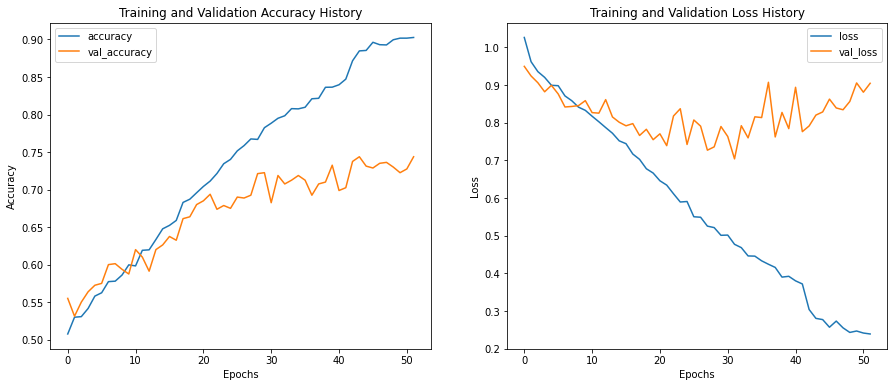

In [39]:
# display training and validation history

# display history of accurracy
plt.figure(figsize= (15,6))
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'], label= 'accuracy' )
plt.plot(history_df['val_accuracy'], label= 'val_accuracy')
# history_df[['acc', 'val_acc']]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()

# display history of loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'], label= 'loss')
plt.plot(history_df['val_loss'], label= 'val_loss')
# history_df[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()

plt.show()

### The training and validation histories show model overfitting.
### This could be as a result of the number of training samples, the quality of the image data or the data distribution 

#### Possible steps of improving the model
1. Acquiring more quality data
2. Utilizing regularization methods
3. Using a model with less capacity

# Model Evaluation

In [40]:
# load best weights into model
model.load_weights('cervicalModel.weights.hdf5')

In [41]:
# save model
model.save('cancer_screen_model.h5')

In [42]:
# evaluate model on test set
model.evaluate(test_gen)

26/26 [==============================] - 3s 102ms/step - loss: 0.7693 - accuracy: 0.7129


[0.7693221569061279, 0.712895393371582]

In [43]:
# with open('cancer.pickle', 'wb') as f:
#     pickle.dump(model, f)

In [44]:
# get test data directory
test_dir = os.path.join(root_dir,'test', 'test')

In [45]:
# load test features and labels
test_filenames = []
test_features = []
for filename in os.listdir(test_dir):
    test_filenames.append(filename)
    filepath = os.path.join(test_dir, filename)
    img = cv2.imread(filepath)
    resized_img = cv2.resize(img, (180, 180))
    test_features.append(np.array(resized_img)) 

In [46]:
# show length of test features and labels
print(len(test_filenames), len(test_features))

512 512


In [47]:
# normalize test features
test_X = np.array(test_features)
test_X = test_X/255

In [48]:
# get test predictions
test_predict = model.predict(test_X)
test_predict[0]

array([0.22174753, 0.39576927, 0.38248327], dtype=float32)

In [49]:
# show encoded classes
le.classes_

array(['Type 1', 'Type 2', 'Type 3'], dtype='<U6')

In [50]:
# create dataframe of test predictions
sub_df = pd.DataFrame(test_predict, columns= ['Type 1', 'Type 2', 'Type 3' ])
sub_df['image_name'] = test_filenames
sub_df = sub_df[['image_name', 'Type 1', 'Type 2', 'Type 3']]
sub_df = sub_df.sort_values(['image_name']).reset_index(drop=True)
sub_df.head()

,image_name,Type 1,Type 2,Type 3
0,0.jpg,0.083906,0.765918,0.150176
1,1.jpg,0.114165,0.229605,0.656229
2,10.jpg,0.000903,0.998795,0.000301
3,100.jpg,0.000586,0.999412,0.000002
4,101.jpg,0.097399,0.463800,0.438801


In [51]:
# create csv file of test predictions
sub_df.to_csv('submission.csv', index=False)